<a href="https://colab.research.google.com/github/Mehvishh25/Image-Segmentation/blob/main/Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers,models
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.F9FDYO_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.F9FDYO_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.


In [ ]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/4.0.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed and
    species. Additionally, head bounding boxes are provided for the training split,
    allowing using this dataset for simple object detection tasks. In the test
    split, the bounding boxes are empty.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir='/root/tensorflow_datasets/oxford_iiit_pet/4.0.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=773.68 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'head_bbox': BBoxFeature(shape=(4,), dtype=float32),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLab

In [ ]:
dataset

{'train': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'head_bbox': TensorSpec(shape=(4,), dtype=tf.float32, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 'test': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'head_bbox': TensorSpec(shape=(4,), dtype=tf.float32, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

In [ ]:
def normalize(input_image,mask_image):
  input_image=tf.cast(input_image,tf.float32)/255.0
  mask_image= mask_image-1
  return input_image,mask_image

def load_train_images(sample):

  input_image=tf.image.resize(sample['image'],(128,128))
  mask_image=tf.image.resize(sample['segmentation_mask'],(128,128))

  if tf.random.uniform(())>0.5:
    input_image=tf.image.flip_left_right(input_image)
    mask_image=tf.image.flip_left_right(mask_image)

  input_image,mask_image=normalize(input_image,mask_image)
  return input_image,mask_image

def load_test_images(sample):

  input_image=tf.image.resize(sample['image'],(128,128))
  mask_image=tf.image.resize(sample['segmentation_mask'],(128,128))

  input_image,mask_image=normalize(input_image,mask_image)
  return input_image,mask_image

In [ ]:
train_dataset= dataset['train'].map(load_train_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset= dataset['test'].map(load_test_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [ ]:
BATCH_SIZE=64
BUFFER_SIZE=1000

train_dataset=train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset=train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset=test_dataset.batch(BATCH_SIZE)

In [ ]:
def display_image(image_list):
  plt.figure(figsize=(10,10))
  title=['Input Image','True Mask','Predicted Mask']

  for i in range(len(image_list)):
    plt.subplot(1,len(image_list),i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(image_list[i]))
    plt.axis('off')

  plt.show()

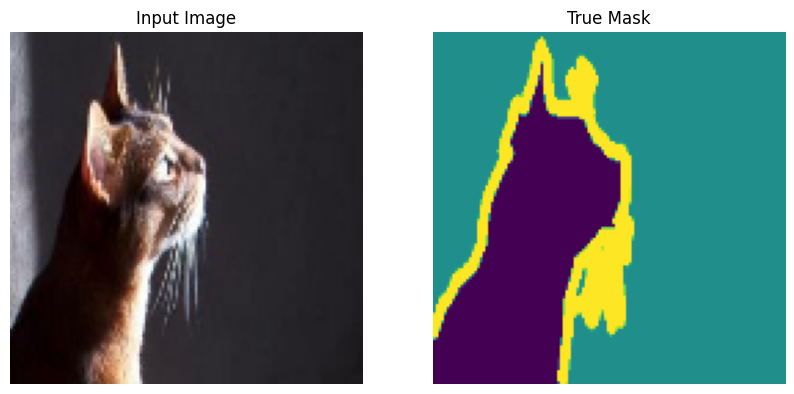

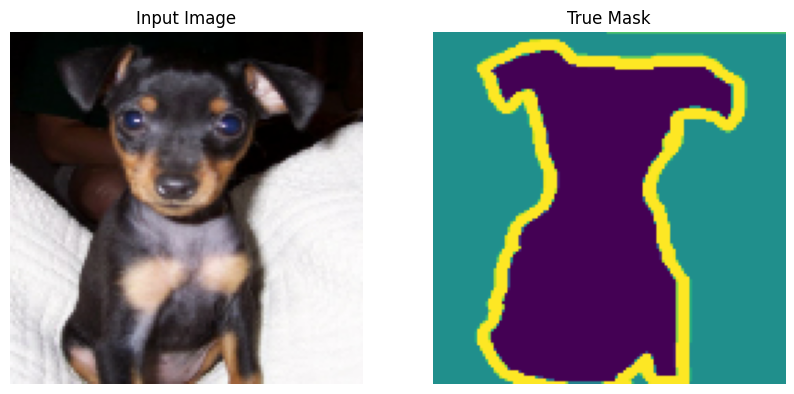

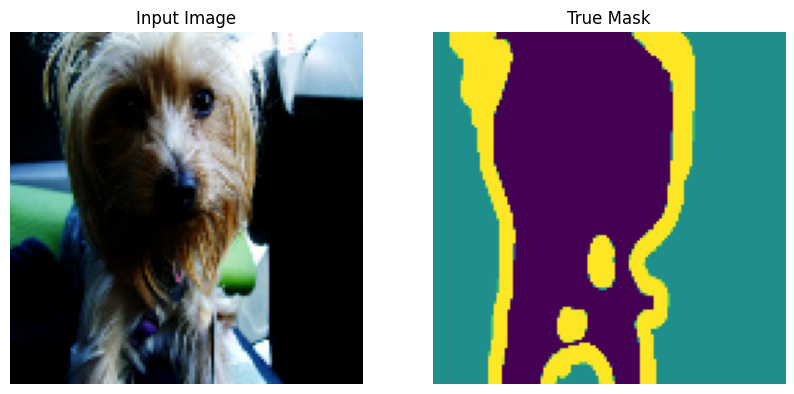

In [ ]:
for images,masks in train_dataset.take(3):
  sample_image, sample_mask= images[0],masks[0]
  display_image([sample_image,sample_mask])

In [ ]:
def double_conv_block(x,n_filters):
  x=layers.Conv2D(n_filters,3,padding='same',activation='relu',kernel_initializer='he_normal')(x)
  x=layers.Conv2D(n_filters,3,padding='same',activation='relu',kernel_initializer='he_normal')(x)
  return x

def downsample_block(x,n_filters):
  f=double_conv_block(x,n_filters)
  p=layers.MaxPool2D(2)(f)
  p=layers.Dropout(0.3)(p)
  return f,p

def upsample_block(x, conv_features, n_filters):
  x=layers.Conv2DTranspose(n_filters,3,2, padding='same')(x)
  x=layers.concatenate([x,conv_features])
  x=layers.Dropout(0.3)(x)
  x=double_conv_block(x,n_filters)
  return x

In [ ]:
def build_unet(output_channels):

  inputs=layers.Input(shape=(128,128,3))

  f1,p1= downsample_block(inputs,64)
  f2,p2=downsample_block(p1,128)
  f3,p3=downsample_block(p2,256)
  f4,p4=downsample_block(p3,512)

  intermediate_block= double_conv_block(p4,1024)

  u6=upsample_block(intermediate_block,f4,512)
  u7=upsample_block(u6,f3,256)
  u8=upsample_block(u7,f2,128)
  u9=upsample_block(u8,f1,64)

  outputs=layers.Conv2D(output_channels,1,padding='same',activation='softmax')(u9)

  unet_model=tf.keras.Model(inputs,outputs,name='U-Net')

  return unet_model

In [ ]:
output_channels = 3
model = build_unet(output_channels)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
!apt-get install graphviz
!pip install pydot

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [ ]:
import graphviz
print(graphviz.__version__)

0.20.3


In [ ]:
model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64, 64, 64)     │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 32, 32, 128)    │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 16, 16, 256)    │              0 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 512)    │      1,180,160 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 8, 8, 512)      │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 8, 8, 512)      │              0 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)    

 Total params: 34,513,475 (131.66 MB)

 Trainable params: 34,513,475 (131.66 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
EPOCHS = 20
steps_per_epoch = info.splits['train'].num_examples // BATCH_SIZE
validation_steps = info.splits['test'].num_examples // BATCH_SIZE

history = model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, validation_data=test_dataset)

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.5580 - loss: 0.9402 - val_accuracy: 0.5961 - val_loss: 0.8107
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.6147 - loss: 0.8192 - val_accuracy: 0.7048 - val_loss: 0.6888
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.7156 - loss: 0.6683 - val_accuracy: 0.7217 - val_loss: 0.6397
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7551 - loss: 0.5885 - val_accuracy: 0.7732 - val_loss: 0.5504
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7818 - loss: 0.5304 - val_accuracy: 0.8006 - val_loss: 0.4873
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8022 - loss: 0.4816 - val_accuracy: 0.8020 - val_loss: 0.4893
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.8147 - loss: 0.4544 - val_accuracy: 0.8280 - val_loss: 0.4254
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8304 - loss: 0.4147 - val_accuracy: 0.8361 - val_los

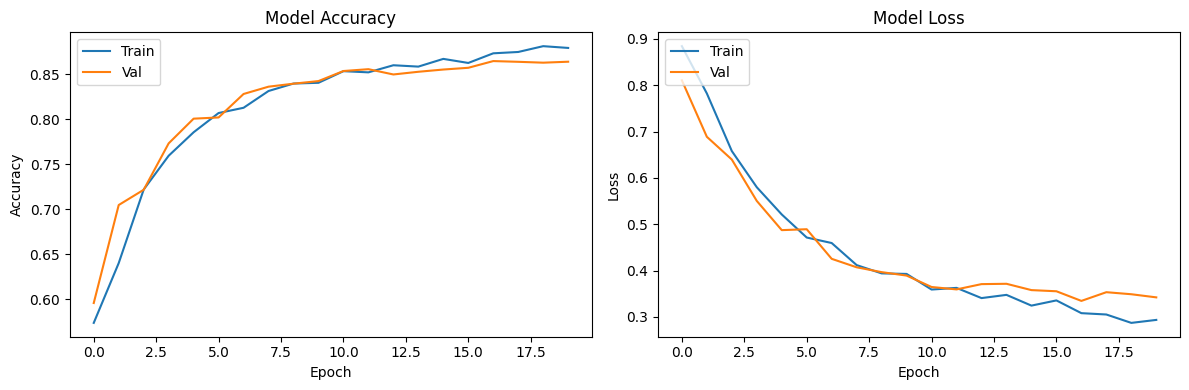

In [ ]:
# plot train & val accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')

# plot train & val loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display_image([image[0], mask[0], create_mask(pred_mask)])

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step


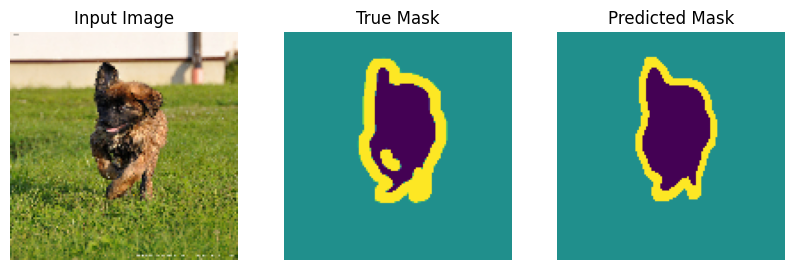

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


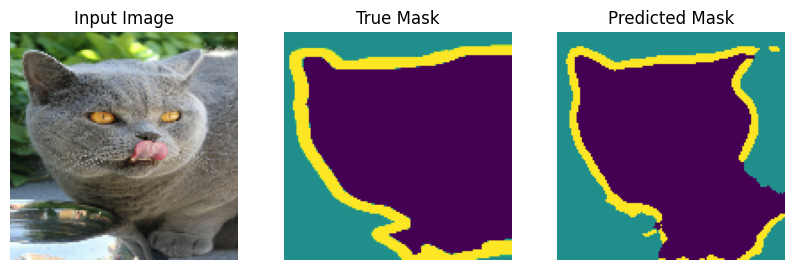

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


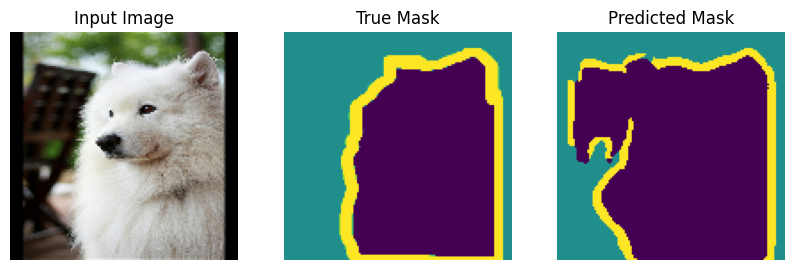

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


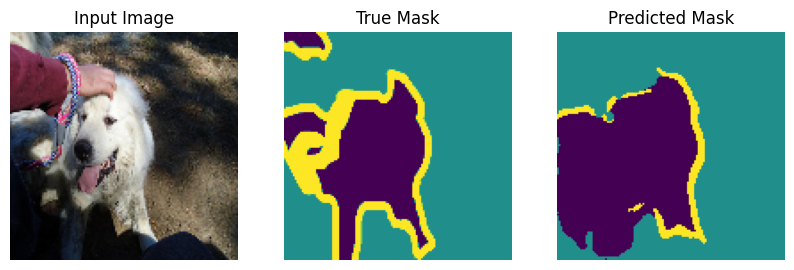

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


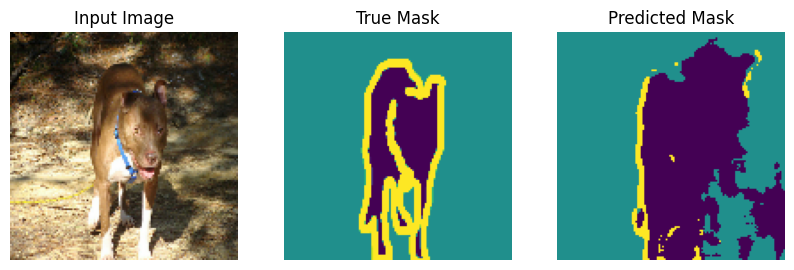

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


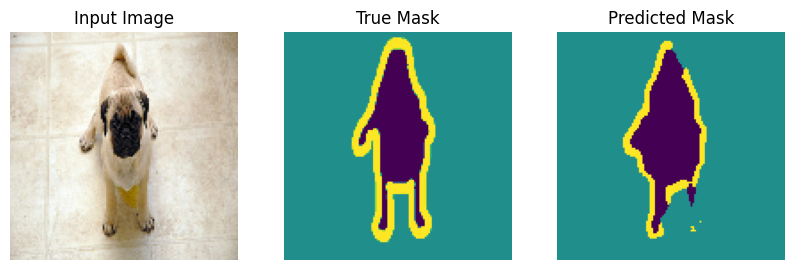

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


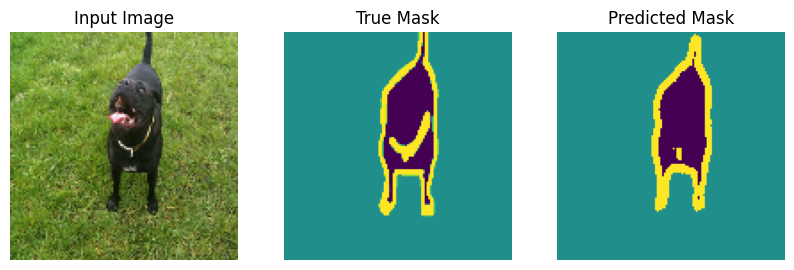

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


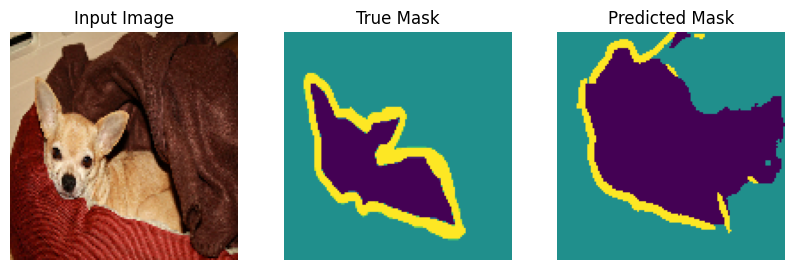

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


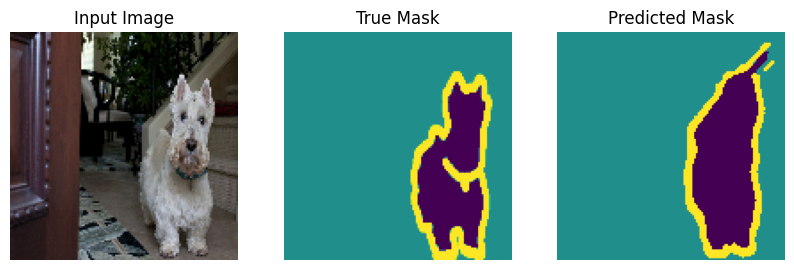

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


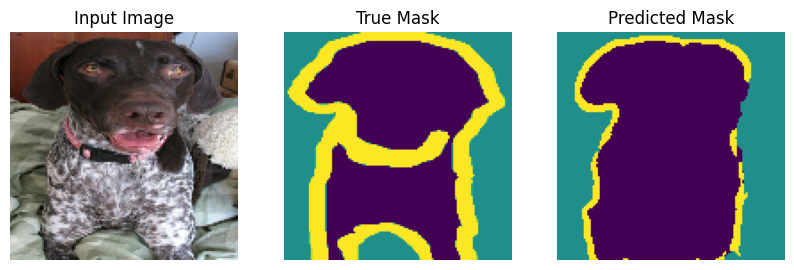

In [ ]:
show_predictions(test_dataset, 10)